In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

In [7]:
data_dir = '/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data'

# Basic dataset
- train: waltz train
- val: waltz test
- test: serrano (all 248 from S1 and S2)

In [13]:
comb_df = pd.read_csv(f'{data_dir}/sbxw_fibrillation_peptide_waltdb-train-val_serrano-test.csv',index_col=0)
comb_df

,sequence,value_bool,data_split,dataset
0,STVPIE,0,val,waltzdb
1,GVIWIA,1,val,waltzdb
2,LATVYA,0,val,waltzdb
3,NATAHQ,0,val,waltzdb
4,STVGIE,0,val,waltzdb
...,...,...,...,...
1642,YLLYYTEFTP,1,test,serrano_s2
1643,TEFTPTEKDE,1,test,serrano_s2
1644,TEKDEYACRV,0,test,serrano_s2
1645,YACRVNHVTL,0,test,serrano_s2


In [15]:
comb_df.groupby(['dataset','data_split']).size()

dataset     data_split
serrano_s1  test           177
serrano_s2  test            71
waltzdb     train         1122
            val            277
dtype: int64

# Padding dataset

Problem: predictors trained on waltzDB dataset sequences, which are all 6 amino acids, can be not be used to classify longer sequences.

Hypothesis: ESM embeddings have a significant length-dependence, e.g. the values in the embedding vectors vary as a function of the length of the sequence. 

Idea: "augment" the sequences in waltzDB by randomly sampling "padding" sequence on the N and C terminus.
- Glycine only, [1-15] residues on either N/C-terminus, 30 residues on either terminus total
- Non-hydrophobic residues (not A,V,I,L,M,W,Y,F), same length distribution

Add serrano s1 sequences, padding if < 30 amino acids to create combined dataset for training

Use serrano s2 sequences for testing and original waltz sequences for testing

# Defining functions

In [16]:
'acdefghiklmnpqrstvwy'.upper()

'ACDEFGHIKLMNPQRSTVWY'

In [17]:
def sampleString(
    charSet,
    length
):
    return ''.join([random.choice(charSet) for _ in range(length)])

def padSequence(
    sequence:str,
    terminal_residue_id:str='gly', #or non-hydrophobic
    n_terminal_residues:tuple=(1,15) #inclusive
):
    
    gly = 'G'
    nonhydrophobic = 'CDEGHKNPQRST'
    
    n_res_nterm = random.randint(*n_terminal_residues)
    n_res_cterm = random.randint(*n_terminal_residues)

    if terminal_residue_id == 'gly':
        padded_seq = sampleString(gly,n_res_nterm)+sequence+sampleString(gly,n_res_cterm)
    elif terminal_residue_id == 'non-hydrophobic':
        padded_seq = sampleString(nonhydrophobic,n_res_nterm)+sequence+sampleString(nonhydrophobic,n_res_cterm)
    else:
        raise ValueError(f"terminal_residue_id == {terminal_residue_id} not recognized")

    mask = ''.join([str(0)]*n_res_nterm+[str(1)]*len(sequence)+[str(0)]*n_res_cterm)
    return padded_seq,mask

random.seed(42)

padSequence('STVPIE','gly')

('GGGGGGGGGGGSTVPIEGG', '0000000000011111100')

# Rand-padded, 10X (pad 10)

In [23]:
pad_max_len = 10
coverage = 10
random.seed(42)
data = list()
for i,row in comb_df.iterrows():
    if row['data_split'] == 'test':
        row_dict = dict(row)
        row_dict['mask'] = ''.join(['1']*len(row['sequence']))
        row_dict['core_sequence'] = row['sequence']
        data.append(row_dict)
    else:
        for j in range(coverage):
            row_dict = dict(row)
            row_dict['sequence'],row_dict['mask'] = padSequence(row.sequence,'non-hydrophobic',(1,pad_max_len))
            row_dict['core_sequence'] = row['sequence']
            data.append(row_dict)
rand_padded_waltz_df = pd.DataFrame(data)
rand_padded_waltz_df['len'] = rand_padded_waltz_df['sequence'].apply(len)
rand_padded_waltz_df.to_csv(f"{data_dir}/sbxw_fibrillation_peptide_waltzdb-train-val_serrano-test_randpadded10x_padlen-{pad_max_len}.csv")
rand_padded_waltz_df

,sequence,value_bool,data_split,dataset,mask,core_sequence,len
0,THSTVPIEG,0,val,waltzdb,001111110,STVPIE,9
1,TDSTSTVPIEQDR,0,val,waltzdb,0000111111000,STVPIE,13
2,CDGGQRCSTVPIEQ,0,val,waltzdb,00000001111110,STVPIE,14
3,NGPRSTVPIEHCETNKHEG,0,val,waltzdb,0000111111000000000,STVPIE,19
4,DNDKKRSTVPIEHC,0,val,waltzdb,00000011111100,STVPIE,14
...,...,...,...,...,...,...,...
14233,YLLYYTEFTP,1,test,serrano_s2,1111111111,YLLYYTEFTP,10
14234,TEFTPTEKDE,1,test,serrano_s2,1111111111,TEFTPTEKDE,10
14235,TEKDEYACRV,0,test,serrano_s2,1111111111,TEKDEYACRV,10
14236,YACRVNHVTL,0,test,serrano_s2,1111111111,YACRVNHVTL,10


<Axes: xlabel='len', ylabel='data_split'>

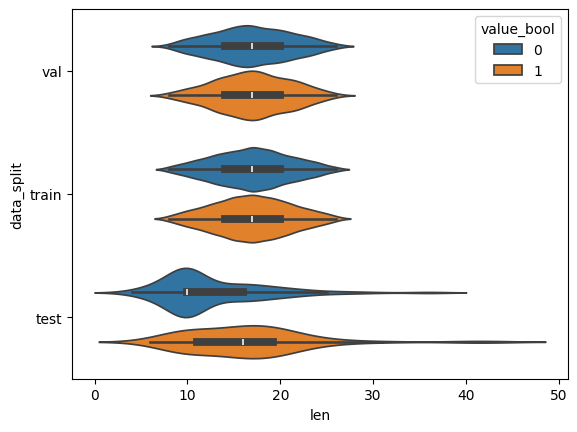

In [24]:
sns.violinplot(rand_padded_waltz_df,
             x='len',
             hue='value_bool',
             y='data_split')

# Rand-padded, 10X (pad 5)

In [25]:
pad_max_len = 5
coverage = 10
random.seed(42)
data = list()
for i,row in comb_df.iterrows():
    if row['data_split'] == 'test':
        row_dict = dict(row)
        row_dict['mask'] = ''.join(['1']*len(row['sequence']))
        row_dict['core_sequence'] = row['sequence']
        data.append(row_dict)
    else:
        for j in range(coverage):
            row_dict = dict(row)
            row_dict['sequence'],row_dict['mask'] = padSequence(row.sequence,'non-hydrophobic',(1,pad_max_len))
            row_dict['core_sequence'] = row['sequence']
            data.append(row_dict)
rand_padded_waltz_df = pd.DataFrame(data)
rand_padded_waltz_df['len'] = rand_padded_waltz_df['sequence'].apply(len)
rand_padded_waltz_df.to_csv(f"{data_dir}/sbxw_fibrillation_peptide_waltzdb-train-val_serrano-test_randpadded10x_padlen-{pad_max_len}.csv")
rand_padded_waltz_df

,sequence,value_bool,data_split,dataset,mask,core_sequence,len
0,TSTVPIEH,0,val,waltzdb,01111110,STVPIE,8
1,ETSTVPIEDS,0,val,waltzdb,0011111100,STVPIE,10
2,RNCCDSTVPIEG,0,val,waltzdb,000001111110,STVPIE,12
3,RCSTVPIEQGTST,0,val,waltzdb,0011111100000,STVPIE,13
4,GPRHCSTVPIEETNK,0,val,waltzdb,000001111110000,STVPIE,15
...,...,...,...,...,...,...,...
14233,YLLYYTEFTP,1,test,serrano_s2,1111111111,YLLYYTEFTP,10
14234,TEFTPTEKDE,1,test,serrano_s2,1111111111,TEFTPTEKDE,10
14235,TEKDEYACRV,0,test,serrano_s2,1111111111,TEKDEYACRV,10
14236,YACRVNHVTL,0,test,serrano_s2,1111111111,YACRVNHVTL,10


<Axes: xlabel='len', ylabel='data_split'>

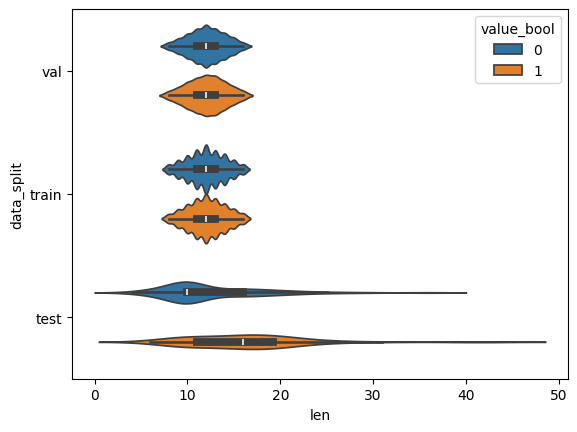

In [26]:
sns.violinplot(rand_padded_waltz_df,
             x='len',
             hue='value_bool',
             y='data_split')

# Rand-padded, 10X (pad 20)

In [27]:
pad_max_len = 20
coverage = 10
random.seed(42)
data = list()
for i,row in comb_df.iterrows():
    if row['data_split'] == 'test':
        row_dict = dict(row)
        row_dict['mask'] = ''.join(['1']*len(row['sequence']))
        row_dict['core_sequence'] = row['sequence']
        data.append(row_dict)
    else:
        for j in range(coverage):
            row_dict = dict(row)
            row_dict['sequence'],row_dict['mask'] = padSequence(row.sequence,'non-hydrophobic',(1,pad_max_len))
            row_dict['core_sequence'] = row['sequence']
            data.append(row_dict)
rand_padded_waltz_df = pd.DataFrame(data)
rand_padded_waltz_df['len'] = rand_padded_waltz_df['sequence'].apply(len)
rand_padded_waltz_df.to_csv(f"{data_dir}/sbxw_fibrillation_peptide_waltzdb-train-val_serrano-test_randpadded10x_padlen-{pad_max_len}.csv")
rand_padded_waltz_df

,sequence,value_bool,data_split,dataset,mask,core_sequence,len
0,THGGSTVPIEE,0,val,waltzdb,00001111110,STVPIE,11
1,DRNCSTVPIECDGGQRCQGTSTQNGPRH,0,val,waltzdb,0000111111000000000000000000,STVPIE,28
2,TSTVPIENKHEGK,0,val,waltzdb,0111111000000,STVPIE,13
3,NDKKSTVPIERHC,0,val,waltzdb,0000111111000,STVPIE,13
4,DNDQHSRKRGTDCSGSTVPIEHDGDNHPSKEKKGSHTSS,0,val,waltzdb,000000000000000111111000000000000000000,STVPIE,39
...,...,...,...,...,...,...,...
14233,YLLYYTEFTP,1,test,serrano_s2,1111111111,YLLYYTEFTP,10
14234,TEFTPTEKDE,1,test,serrano_s2,1111111111,TEFTPTEKDE,10
14235,TEKDEYACRV,0,test,serrano_s2,1111111111,TEKDEYACRV,10
14236,YACRVNHVTL,0,test,serrano_s2,1111111111,YACRVNHVTL,10


<Axes: xlabel='len', ylabel='data_split'>

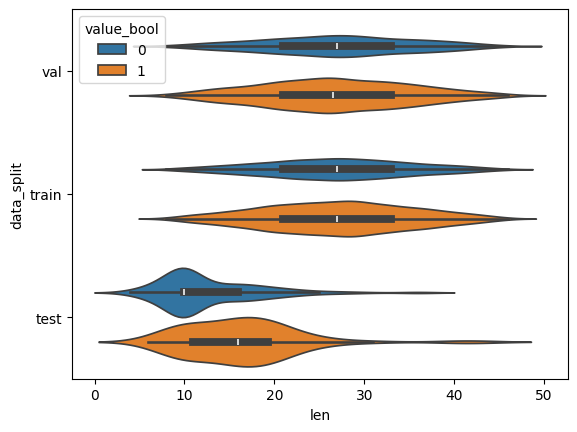

In [28]:
sns.violinplot(rand_padded_waltz_df,
             x='len',
             hue='value_bool',
             y='data_split')

# Check for leakage

In [108]:
rand_padded_waltz_df.groupby('data_split').core_sequence.nunique()

data_split
test      247
train    1122
val       277
Name: core_sequence, dtype: int64

In [110]:
rand_padded_waltz_df.groupby('data_split').core_sequence.nunique().sum()

1646

In [109]:
rand_padded_waltz_df.core_sequence.nunique()

1645

one seq is repeated...

In [126]:
first_df = rand_padded_waltz_df.groupby(['data_split','core_sequence'],as_index=False).first()
first_df

,data_split,core_sequence,sequence,value_bool,dataset,mask,len
0,test,AAAGAVVGGL,AAAGAVVGGL,0,serrano_s2,1111111111,10
1,test,ADAVACAKRV,ADAVACAKRV,0,serrano_s2,1111111111,10
2,test,AKKENIIAAAQAGASGY,AKKENIIAAAQAGASGY,1,serrano_s1,11111111111111111,17
3,test,AKNVDYCKEWLVNHIK,AKNVDYCKEWLVNHIK,0,serrano_s1,1111111111111111,16
4,test,AMALNCDPVWLQYGTKRGKA,AMALNCDPVWLQYGTKRGKA,0,serrano_s1,11111111111111111111,20
...,...,...,...,...,...,...,...
1641,val,YNNTGS,ENESSEYNNTGSDQRCR,0,waltzdb,00000011111100000,17
1642,val,YNPDAG,EQEPNSYNPDAGGN,0,waltzdb,00000011111100,14
1643,val,YQAYNA,EHDEHYQAYNANSE,0,waltzdb,00000111111000,14
1644,val,YSGSNS,SYSGSNSCRP,0,waltzdb,0111111000,10


In [128]:
first_df[first_df.duplicated(subset='core_sequence',keep=False)]

,data_split,core_sequence,sequence,value_bool,dataset,mask,len
227,test,VQIVYK,VQIVYK,1,serrano_s1,111111,6
1265,train,VQIVYK,KHVQIVYKEGPGRS,1,waltzdb,00111111000000,14
